In [1]:
import sys
from collections import namedtuple, Counter
from itertools import combinations, starmap
from numpy import *
import random
import itertools

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib

from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import *

import pickle

import numpy as np
import collections
import time
import operator

#from pathos.multiprocessing import ProcessingPool as Pool
from operator import add

from keras.models import load_model

import matplotlib.patches as mpatches


SUITS = ["1", "2", "3", "4"]
RANKS = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13"]
VALUES = [1, 2, 3, 4, 5, 6, 7, 8, 9 , 10, 10, 10, 10]
val_dict = dict(zip(RANKS, VALUES))


Using TensorFlow backend.


In [2]:
### Helper functions for scoring and so on

def scoreHand(hand):
    ### This function is still a little imperfect but I think it does the job.
    ### It ends up being the bottleneck in training data generation
    
    _handRanks = [x[:-2] for x in hand]
    _handSuits = [x[-1:] for x in hand]
    #print(_handSuits)
    score = 0

    ## pairs, trips, quads
    duplicates = {x:y for x, y in collections.Counter(_handRanks).items() if y > 1}
    for v in duplicates:
        if duplicates[v] == 2:
            score = score + 2
        elif duplicates[v] == 3:
            score = score + 6
        elif duplicates[v] == 4:
            score = score + 12

    #print("Score from pairs: "+str(score))
    handCombinations = []
    for i in range(2, 5):
        els = [list(x) for x in itertools.combinations(_handRanks, i)]
        handCombinations.extend(els)

    ## 15s
    fifteenScore = 0
    for combo in handCombinations:
        comboScore = 0
        for i in range(0, len(combo)):
            cardValue = val_dict[combo[i]]
            comboScore = comboScore + cardValue

        if comboScore == 15:
            #print("Fifteen for 2: " + str(combo))
            score = score + 2
            fifteenScore = fifteenScore + 2

    #print("Score from 15s: "+str(fifteenScore))

    # flush
    if (sum(x == _handSuits[0] for x in _handSuits))==5:
        score = score + 5
    #    print("flush 5")
    elif (sum(x == _handSuits[0] for x in _handSuits[0:4]))==4:
        score = score + 4
    #    print("flush 4")

    # Nob can be calculated here, but I'm not really sure we need that .. yet?

    ## runs ... oh god why

    numerRanks = [int(x[:-2]) for x in hand]
    
    if sum(numerRanks)*1.0 == ((max(numerRanks)*(max(numerRanks)+1)/2-min(numerRanks)*(min(numerRanks)-1)/2)) and len(_handRanks)==len(set(numerRanks)):
    #    print("run of 5")
        score = score + 5
    else:
        y=0
        for i in itertools.combinations(numerRanks, 4):
            if sum(i)*1.0 == ((max(i)*(max(i)+1)/2-min(i)*(min(i)-1)/2)) and len(i)==len(set(i)):
                #            print("run of 4")
                score = score + 4
                y+=1
        if y==0:
            for i in itertools.combinations(numerRanks, 3):
                if sum(i)*1.0 == ((max(i)*(max(i)+1)/2-min(i)*(min(i)-1)/2)) and len(i)==len(set(i)):
                    #            print("run of 3")
                    score = score + 3
                    y+=1
            

    return score

def calcMarginsFromSinglePlay(_iKept, _iThrew, _theyKept, _theyThrew, _whoseCrib, modelIn):
    
    ### This is how we compare the player to the AI
    ### To minimize variance, the results are averaged over all possible flip cards
    
    score=0

    suits = '1 2 3 4'.split()
    ranks = '2 3 4 5 6 7 8 9 10 11 12 13 1'.split()
    deck  = [r + ' ' + s for s in suits for r in ranks]

    for j in range(len(_iKept)):
        deck.remove(_iKept[j])

    for j in range(len(_iThrew)):
        deck.remove(_iThrew[j])

    for j in range(len(_theyKept)):
        deck.remove(_theyKept[j])

    for j in range(len(_theyThrew)):
        deck.remove(_theyThrew[j])

    for j in range(len(deck)):
        flipCard=deck[j]
        all1=_iKept+[flipCard]
        all2=_theyKept+[flipCard]
        allc=_iThrew+_theyThrew+[flipCard]

        iscore1=scoreHand(all1)
        iscore2=scoreHand(all2)
        iscorec=scoreHand(allc)

        score+=iscore1-iscore2+_whoseCrib*iscorec

    return score/len(deck)
    
    
def toCardText(cardList):
    ### Converts internal card format ['3 4'] to readable format ['3h']
    
    
    numerizedList=[int(i.split(' ', 1)[0]) for i in cardList]+[int(i.split(' ', 1)[1]) for i in cardList] 

    reada=['K' if x==13 else x for x in numerizedList]
    reada=['Q' if x==12 else x for x in reada]
    reada=['J' if x==11 else x for x in reada]
    reada=['T' if x==10 else x for x in reada]
    reada=['A' if x==1 else x for x in reada]

    readb=['h' if x==1 else x for x in numerizedList]
    readb=['c' if x==2 else x for x in readb]
    readb=['d' if x==3 else x for x in readb]
    readb=['s' if x==4 else x for x in readb]
    
    returnString=""
    for i in range(len(cardList)):
        returnString+=str(reada[i])+str(readb[i+len(cardList)])+" "
    return returnString


In [3]:
### Load a bunch of saved stuff

# the model

modelt = load_model('bestThrowingWeights.h5')

# around 300 games I played against the computer

with open('benchmark2.pkl', 'rb') as f:  # Python 3: open(..., 'wb')
    dealtToMeList, theyKeptList, theyThrewList, iKeptList, iThrewList, flipCardList, whoseCribList = pickle.load(f)


In [4]:
### Start off a new game here - wipes the cache of previous games and deals one hand

crib=1
humanScores=[]
aiScores=[]
dealtToMeList=[]
dealtToThemList=[]
iKeptList=[]
iThrewList=[]
theyKeptList=[]
theyThrewList=[]
flipCardList=[]
whoseCribList=[]
numOfGames=0
suits = '1 2 3 4'.split()
ranks = '2 3 4 5 6 7 8 9 10 11 12 13 1'.split()
deck  = [r + ' ' + s for s in suits for r in ranks]
n_players = 2
hand_size = 6

random.shuffle(deck)
#deals = deal(deck, n_players, hand_size)
dealtToMe = deck[0:6]
crib=crib*-1

print(crib)
print(toCardText(dealtToMe))
##print(" 1  2  3  4  5  6")

-1
8d 8s Kd Kh Th 8c 


In [5]:
### Pick cards to throw (not zero indexed)

throw=[2,5]

In [24]:



leftOvers=[1,2,3,4,5,6]
leftOvers.remove(throw[0])
leftOvers.remove(throw[1])
leftOvers

iThrew=[dealtToMe[throw[0]-1],dealtToMe[throw[1]-1]]
iKept=[dealtToMe[leftOvers[0]-1],dealtToMe[leftOvers[1]-1],dealtToMe[leftOvers[2]-1],dealtToMe[leftOvers[3]-1]]

iKeptList+=[iThrew]
iThrewList+=[iKept]

dealtToThem = deck[6:12]

theirHands = [[] for _ in range(15)]
theirKeeps = [[] for _ in range(15)]
theirThrows = [[] for _ in range(15)]
i=0
for subset in itertools.combinations(dealtToThem, 2):
    y = dealtToThem[:]
    y.remove(subset[0])
    y.remove(subset[1])
    theirKeeps[i]=list(y)
    theirThrows[i]=list(subset)
    theirHands[i]=list(y)+list(subset)
    i+=1

numericalHands=[]
for q in range(len(theirHands)):
    hand=theirHands[q]
    numericalHands+=[[-1*crib]+[int(i.split(' ', 1)[0]) for i in hand]+[int(i.split(' ', 1)[1]) for i in hand] ]
#print(numericalHands)
outs=modelt.predict(numericalHands)
index, value = max(enumerate(outs), key=operator.itemgetter(1))

win=numericalHands[index]

theyKept=theirKeeps[index]
theyThrew=theirThrows[index]

flipCard=deck[13]

all1=iKept+[flipCard]
all2=theyKept+[flipCard]
allc=iThrew+theyThrew+[flipCard]

score1=scoreHand(all1)
score2=scoreHand(all2)
scorec=scoreHand(allc)


cribMid=(crib==1)*toCardText(theyThrew)+(crib==-1)*toCardText(iThrew)

print("me:   ",toCardText(iKept)," =",score1)
print("                  ",(crib==1)*toCardText(iThrew))
print("     ",toCardText([flipCard]),"        ",cribMid," =",scorec)
print("                  ",(crib==-1)*toCardText(theyThrew))
print("them:   ",toCardText(theyKept)," =",score2)

numOfGames+=1
huSc=calcMarginsFromSinglePlay(iKept,iThrew,theyKept,theyThrew,crib,modelt)
humanScores+=[huSc]

aiHands = [[] for _ in range(15)]
aiKeeps = [[] for _ in range(15)]
aiThrows = [[] for _ in range(15)]
i=0

for subset in itertools.combinations(dealtToMe, 2):
    y = dealtToMe[:]
    y.remove(subset[0])
    y.remove(subset[1])
    aiKeeps[i]=list(y)
    aiThrows[i]=list(subset)
    aiHands[i]=list(y)+list(subset)
    i+=1

numericalHands=[]
for q in range(len(aiHands)):
    hand=aiHands[q]
    numericalHands+=[[crib]+[int(i.split(' ', 1)[0]) for i in hand]+[int(i.split(' ', 1)[1]) for i in hand] ]
#print(numericalHands)
aiouts=modelt.predict(numericalHands)
index, value = max(enumerate(aiouts), key=operator.itemgetter(1))

aiwin=numericalHands[index]

aiKept=aiKeeps[index]
aiThrew=aiThrows[index]

aiall1=aiKept+[flipCard]
aiall2=theyKept+[flipCard]
aiallc=aiThrew+theyThrew+[flipCard]

aiscore1=scoreHand(aiall1)
aiscore2=scoreHand(aiall2)
aiscorec=scoreHand(aiallc)


aiSc=calcMarginsFromSinglePlay(aiKept,aiThrew,theyKept,theyThrew,crib,modelt)
aiScores+=[aiSc]
dealtToMeList+=[dealtToMe]
dealtToThemList+=[dealtToThem]
theyKeptList+=[theyKept]
theyThrewList+=[theyThrew]
flipCardList+=[flipCard]
whoseCribList+=[crib]

print()
print()
print("     human: ", sum(humanScores),"points ","+/- ",2*sqrt(np.var(humanScores))*sqrt(len(humanScores)))
print("           ",numOfGames, " hands")

print()


print()
print("     ai:    ", sum(aiScores),"points ")
print()
print("             diff=",sum(humanScores)-sum(aiScores)," +/- ",2*sqrt(np.var(np.array(humanScores)-np.array(aiScores)))*sqrt(len(humanScores)))





print()

print(" ")
print(" ")
suits = '1 2 3 4'.split()
ranks = '2 3 4 5 6 7 8 9 10 11 12 13 1'.split()
deck  = [r + ' ' + s for s in suits for r in ranks]
n_players = 2
hand_size = 6

random.shuffle(deck)
#deals = deal(deck, n_players, hand_size)
dealtToMe = deck[0:6]
crib=crib*-1

print(crib)
print(toCardText(dealtToMe))
print(" 1  2  3  4  5  6")

me:    8c 9h 3s 7c   = 8
                   
      6h           Kh 3d   = 8
                   6s 9d 
them:    Ac 4d Js 8h   = 4


     human:  -62.8 points  +/-  57.0655118882
            17  hands


     ai:     10.725 points 

             diff= -73.525  +/-  36.6668787873

 
 
1
7h Jh Kd 6s Ad Qs 
 1  2  3  4  5  6


In [7]:
### To continue playing, select cards to throw and execute the previous block

throw=[2,5]

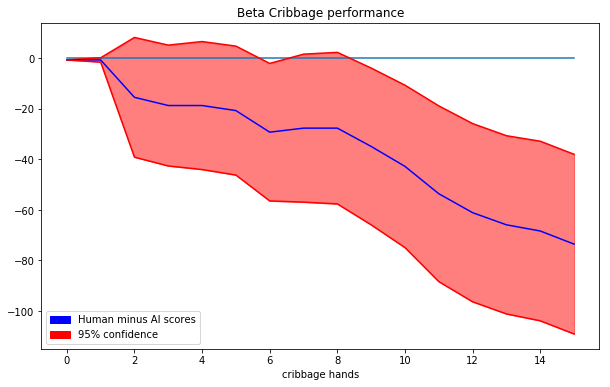

In [25]:
### Visualizes player's progress compared to AI playing in human's place

runningTotal=[]
runningVar=[]
runningMarHi=[]
runningMarLo=[]
zippo=[]
for i in range(1,len(humanScores)):
    runningTotal+=[sum(humanScores[:i])-sum(aiScores[:i])]
    runningVar+=[2*sqrt(np.var(np.array(humanScores[:i])-np.array(aiScores[:i])))*sqrt(len(humanScores[:i]))]
    runningMarHi+=[sum(humanScores[:i])-sum(aiScores[:i])+2*sqrt(np.var(np.array(humanScores[:i])-np.array(aiScores[:i])))*sqrt(len(humanScores[:i]))]
    runningMarLo+=[sum(humanScores[:i])-sum(aiScores[:i])-2*sqrt(np.var(np.array(humanScores[:i])-np.array(aiScores[:i])))*sqrt(len(humanScores[:i]))]                                                                                   
    zippo+=[0]
    
plt.figure(figsize=(10,6))
plt.plot(range(len(zippo)),zippo)
a=plt.plot(range(len(runningMarHi)),runningMarHi,'r')
b=plt.plot(range(len(runningTotal)),runningTotal,'b')
c=plt.plot(range(len(runningMarLo)),runningMarLo,'r')

plt.fill_between(range(len(runningMarLo)), runningMarLo, runningMarHi, color='red', alpha='0.5')

red_patch = mpatches.Patch(color='blue', label='Human minus AI scores')
blue_patch = mpatches.Patch(color='red', label='95% confidence')

plt.legend(handles=[red_patch, blue_patch],loc=3)
plt.title('Beta Cribbage performance')
plt.xlabel('cribbage hands')



plt.show()